## Классификация изображений
### Вводные слова
Задача классификации изображений - это одна из ключевых задач в области компьютерного зрения и машинного обучения. Она заключается в том, чтобы разработать модель, способную автоматически определить, к какому классу или категории принадлежит данное изображение. Классификация используется в следующих задачах: классификация спектрограмм музыкальных записей для выявления предпочтений конкретного пользователя, классификация изображений для автоматической идентификации людей на фотографиях, кластеризация покупок пользователя в интернет-магазине для формирования целевой рекламы, и так далее
### Рекомендации
Работу лучше выполнять в среде Google Colab, поскольку потребуется осуществлять вычисления на видеокарте. В Colab в меню нажмите на Изменить->Настройки блокнота и выберите доступный GPU. Это позволит использовать для обучения CUDA
### Цель работы и задачи
В данной работе мы разработаем модель, для предсказания класса на датасете cifar-10. Ниже будет представлена baseline модель, основываясь на которой вы можете строить свою модель для классификации
\
Задачи, которые вам нужно решить в работе:
\
Обязательные:
- Построить распределение классов в данных
- Подготовить данные и обучить baseline-модель на датасете
- Оценить качество модели
- Написать свою модель и обучить ее

Желательные:
- Подумать об архитектуре модели, быть может стоит сделать ее глубже, добавить боковые связи и т.д.
- Задуматься об аугментации
- Попробовать transfer-learning

\
\
Ваша работа будет оцениваться исходя из 2 факторов:
- контрольная метрика
- протокол исследования, которым и будет служить этот Jupyter-Notebook

\
Максимальный балл за работу - 20.
\
Удачи!

## Baseline-модель

In [14]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from torch.functional import F

Обучать мы будем, разумеется, на cuda, поэтому, создадим переменную device, которая будет зависеть от того, доступна ли видеокарта для вычислений

In [15]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Running on {device}')

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Running on cuda


In [16]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x


Загрузим данные, построим диаграммы для распределения классов и посмотрим на сами картинки

Files already downloaded and verified
Files already downloaded and verified


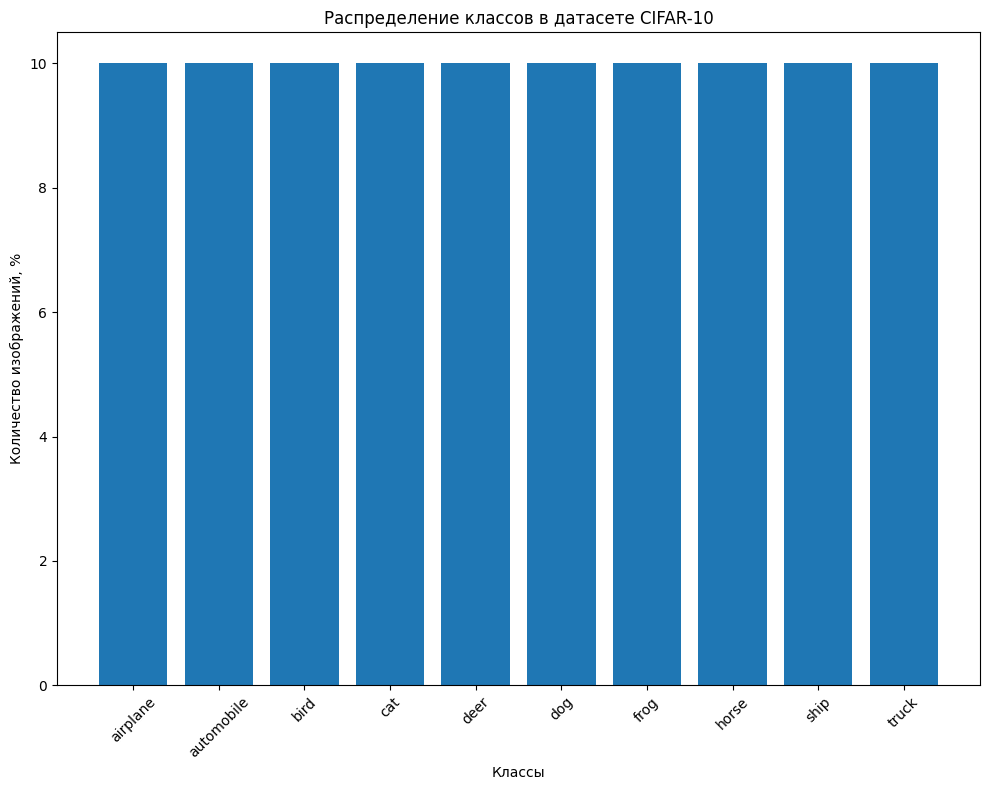

In [17]:
# Будем превращать картинку в torch.Tensor
transform = transforms.ToTensor()

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Трансформация для тестовых данных
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Загрузка датасетов
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform_train, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform_test, download=True)

# Получим метки классов
class_labels = train_dataset.classes
class_counts = np.array([0] * len(class_labels))

# Посчитаем число меток классов
for _, label in train_dataset:
    class_counts[label] += 1

class_counts = class_counts / class_counts.sum() * 100

# Построим диаграмму
plt.figure(figsize=(10, 8))
plt.bar(class_labels, class_counts)
plt.xlabel('Классы')
plt.ylabel('Количество изображений, %')
plt.title('Распределение классов в датасете CIFAR-10')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

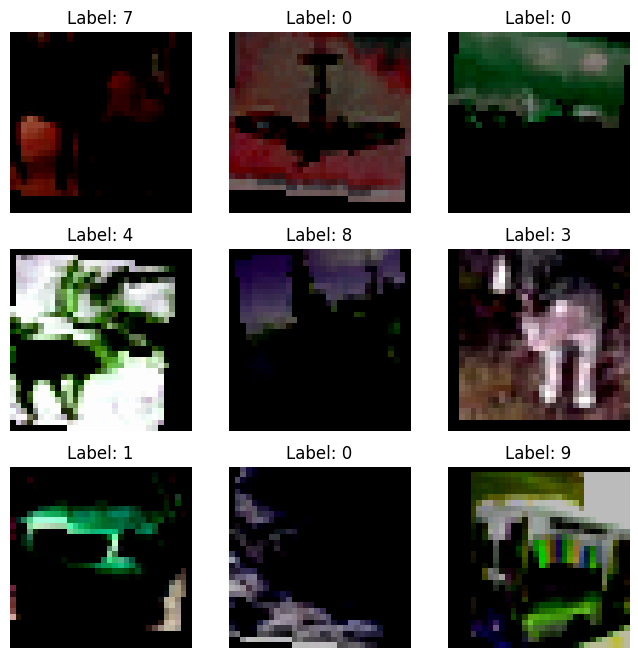

In [18]:
indices = np.random.choice(len(train_dataset), 9, replace=False)

fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    image, label = train_dataset[indices[i]]
    image = image.numpy().transpose((1, 2, 0))
    ax.imshow(image)
    ax.set_title(f'Label: {label}')
    ax.axis('off')

plt.show()

Сделайте вывод о сбалансированности датасета:
\
Исходя из этого, какие метрики будем применять для оценки качества модели?

Напишем функции train и test

In [19]:
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=10):
    model.train()
    model = model.to(device)
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        pbar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=100, desc=f'Train epoch {epoch + 1}/{epochs}')
        for batch_idx, (inputs, labels) in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            pbar.set_postfix({'loss': f'{running_loss / (batch_idx + 1):.4f}', 'accuracy': f'{correct / total:.4f}'})

        train_loss_history.append(running_loss / len(train_loader))
        train_acc_history.append(correct / total)

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss_history.append(val_loss / len(val_loader))
        val_acc_history.append(val_correct / val_total)

        scheduler.step()

        print(f'Epoch {epoch + 1}/{epochs} -> Train Loss: {running_loss / len(train_loader):.4f}, Train Acc: {correct / total:.4f}, Val Loss: {val_loss / len(val_loader):.4f}, Val Acc: {val_correct / val_total:.4f}')

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

def test(model, test_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    average_loss = test_loss / len(test_loader)

    return accuracy, average_loss

Сделайте разделение на train и val
\
Зачем так делать?

In [20]:
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

Создайте Dataloader'ы и настройте гиперпараметры, оптимизатор и функцию потерь
\
Какой оптимизатор будете использовать и почему, а какую loss-функцию?

In [10]:
learning_rate = 0.001
num_epochs = 30
batch_size = 64

# Модель
model = CustomCNN(num_classes=10)
print('Model params: ', count_parameters(model))

# Функция потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Планировщик обучения
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# DataLoader'ы
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Model params:  3064586


Обучите модель и постройте графики обучения

In [21]:
train_loss_history, train_acc_history, val_loss_history, val_acc_history = train(
    model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=num_epochs
)


Train epoch 1/30: 100%|█████████████| 625/625 [00:53<00:00, 11.61it/s, loss=1.0374, accuracy=0.6388]


Epoch 1/30 -> Train Loss: 1.0374, Train Acc: 0.6388, Val Loss: 0.6423, Val Acc: 0.7778


Train epoch 2/30: 100%|█████████████| 625/625 [00:54<00:00, 11.56it/s, loss=0.6887, accuracy=0.7575]


Epoch 2/30 -> Train Loss: 0.6887, Train Acc: 0.7575, Val Loss: 0.5596, Val Acc: 0.8034


Train epoch 3/30: 100%|█████████████| 625/625 [00:54<00:00, 11.41it/s, loss=0.6226, accuracy=0.7836]


Epoch 3/30 -> Train Loss: 0.6226, Train Acc: 0.7836, Val Loss: 0.5715, Val Acc: 0.8028


Train epoch 4/30: 100%|█████████████| 625/625 [00:53<00:00, 11.63it/s, loss=0.5927, accuracy=0.7924]


Epoch 4/30 -> Train Loss: 0.5927, Train Acc: 0.7924, Val Loss: 0.5514, Val Acc: 0.8114


Train epoch 5/30: 100%|█████████████| 625/625 [00:53<00:00, 11.68it/s, loss=0.5714, accuracy=0.7989]


Epoch 5/30 -> Train Loss: 0.5714, Train Acc: 0.7989, Val Loss: 0.5539, Val Acc: 0.8134


Train epoch 6/30: 100%|█████████████| 625/625 [00:53<00:00, 11.72it/s, loss=0.5599, accuracy=0.8045]


Epoch 6/30 -> Train Loss: 0.5599, Train Acc: 0.8045, Val Loss: 0.5291, Val Acc: 0.8216


Train epoch 7/30: 100%|█████████████| 625/625 [00:52<00:00, 11.82it/s, loss=0.5510, accuracy=0.8087]


Epoch 7/30 -> Train Loss: 0.5510, Train Acc: 0.8087, Val Loss: 0.5162, Val Acc: 0.8257


Train epoch 8/30: 100%|█████████████| 625/625 [00:54<00:00, 11.54it/s, loss=0.5395, accuracy=0.8117]


Epoch 8/30 -> Train Loss: 0.5395, Train Acc: 0.8117, Val Loss: 0.5071, Val Acc: 0.8302


Train epoch 9/30: 100%|█████████████| 625/625 [00:53<00:00, 11.64it/s, loss=0.5270, accuracy=0.8142]


Epoch 9/30 -> Train Loss: 0.5270, Train Acc: 0.8142, Val Loss: 0.5232, Val Acc: 0.8244


Train epoch 10/30: 100%|████████████| 625/625 [00:53<00:00, 11.79it/s, loss=0.5195, accuracy=0.8180]


Epoch 10/30 -> Train Loss: 0.5195, Train Acc: 0.8180, Val Loss: 0.5051, Val Acc: 0.8336


Train epoch 11/30: 100%|████████████| 625/625 [00:53<00:00, 11.67it/s, loss=0.5004, accuracy=0.8250]


Epoch 11/30 -> Train Loss: 0.5004, Train Acc: 0.8250, Val Loss: 0.5021, Val Acc: 0.8304


Train epoch 12/30: 100%|████████████| 625/625 [00:53<00:00, 11.63it/s, loss=0.4943, accuracy=0.8257]


Epoch 12/30 -> Train Loss: 0.4943, Train Acc: 0.8257, Val Loss: 0.5054, Val Acc: 0.8332


Train epoch 13/30: 100%|████████████| 625/625 [00:52<00:00, 11.87it/s, loss=0.4854, accuracy=0.8302]


Epoch 13/30 -> Train Loss: 0.4854, Train Acc: 0.8302, Val Loss: 0.4990, Val Acc: 0.8314


Train epoch 14/30: 100%|████████████| 625/625 [00:51<00:00, 12.07it/s, loss=0.4890, accuracy=0.8270]


Epoch 14/30 -> Train Loss: 0.4890, Train Acc: 0.8270, Val Loss: 0.4955, Val Acc: 0.8345


Train epoch 15/30: 100%|████████████| 625/625 [00:51<00:00, 12.16it/s, loss=0.4825, accuracy=0.8327]


Epoch 15/30 -> Train Loss: 0.4825, Train Acc: 0.8327, Val Loss: 0.5091, Val Acc: 0.8314


Train epoch 16/30: 100%|████████████| 625/625 [00:52<00:00, 12.01it/s, loss=0.4785, accuracy=0.8314]


Epoch 16/30 -> Train Loss: 0.4785, Train Acc: 0.8314, Val Loss: 0.4958, Val Acc: 0.8371


Train epoch 17/30: 100%|████████████| 625/625 [00:52<00:00, 11.91it/s, loss=0.4791, accuracy=0.8295]


Epoch 17/30 -> Train Loss: 0.4791, Train Acc: 0.8295, Val Loss: 0.4901, Val Acc: 0.8386


Train epoch 18/30: 100%|████████████| 625/625 [00:52<00:00, 12.02it/s, loss=0.4724, accuracy=0.8339]


Epoch 18/30 -> Train Loss: 0.4724, Train Acc: 0.8339, Val Loss: 0.5017, Val Acc: 0.8344


Train epoch 19/30: 100%|████████████| 625/625 [00:51<00:00, 12.05it/s, loss=0.4715, accuracy=0.8334]


Epoch 19/30 -> Train Loss: 0.4715, Train Acc: 0.8334, Val Loss: 0.4994, Val Acc: 0.8348


Train epoch 20/30: 100%|████████████| 625/625 [00:52<00:00, 11.91it/s, loss=0.4630, accuracy=0.8364]


Epoch 20/30 -> Train Loss: 0.4630, Train Acc: 0.8364, Val Loss: 0.4916, Val Acc: 0.8362


Train epoch 21/30: 100%|████████████| 625/625 [00:54<00:00, 11.45it/s, loss=0.4557, accuracy=0.8390]


Epoch 21/30 -> Train Loss: 0.4557, Train Acc: 0.8390, Val Loss: 0.4918, Val Acc: 0.8360


Train epoch 22/30: 100%|████████████| 625/625 [00:54<00:00, 11.40it/s, loss=0.4575, accuracy=0.8387]


Epoch 22/30 -> Train Loss: 0.4575, Train Acc: 0.8387, Val Loss: 0.4837, Val Acc: 0.8414


Train epoch 23/30: 100%|████████████| 625/625 [00:54<00:00, 11.42it/s, loss=0.4531, accuracy=0.8423]


Epoch 23/30 -> Train Loss: 0.4531, Train Acc: 0.8423, Val Loss: 0.4910, Val Acc: 0.8377


Train epoch 24/30: 100%|████████████| 625/625 [00:54<00:00, 11.43it/s, loss=0.4453, accuracy=0.8431]


Epoch 24/30 -> Train Loss: 0.4453, Train Acc: 0.8431, Val Loss: 0.4917, Val Acc: 0.8380


Train epoch 25/30: 100%|████████████| 625/625 [00:54<00:00, 11.52it/s, loss=0.4515, accuracy=0.8405]


Epoch 25/30 -> Train Loss: 0.4515, Train Acc: 0.8405, Val Loss: 0.4860, Val Acc: 0.8367


Train epoch 26/30: 100%|████████████| 625/625 [00:53<00:00, 11.64it/s, loss=0.4518, accuracy=0.8408]


Epoch 26/30 -> Train Loss: 0.4518, Train Acc: 0.8408, Val Loss: 0.4900, Val Acc: 0.8379


Train epoch 27/30: 100%|████████████| 625/625 [00:54<00:00, 11.37it/s, loss=0.4485, accuracy=0.8432]


Epoch 27/30 -> Train Loss: 0.4485, Train Acc: 0.8432, Val Loss: 0.4869, Val Acc: 0.8406


Train epoch 28/30: 100%|████████████| 625/625 [00:53<00:00, 11.59it/s, loss=0.4413, accuracy=0.8445]


Epoch 28/30 -> Train Loss: 0.4413, Train Acc: 0.8445, Val Loss: 0.4881, Val Acc: 0.8393


Train epoch 29/30: 100%|████████████| 625/625 [00:54<00:00, 11.48it/s, loss=0.4423, accuracy=0.8446]


Epoch 29/30 -> Train Loss: 0.4423, Train Acc: 0.8446, Val Loss: 0.4873, Val Acc: 0.8398


Train epoch 30/30: 100%|████████████| 625/625 [00:53<00:00, 11.60it/s, loss=0.4404, accuracy=0.8469]


Epoch 30/30 -> Train Loss: 0.4404, Train Acc: 0.8469, Val Loss: 0.4861, Val Acc: 0.8403


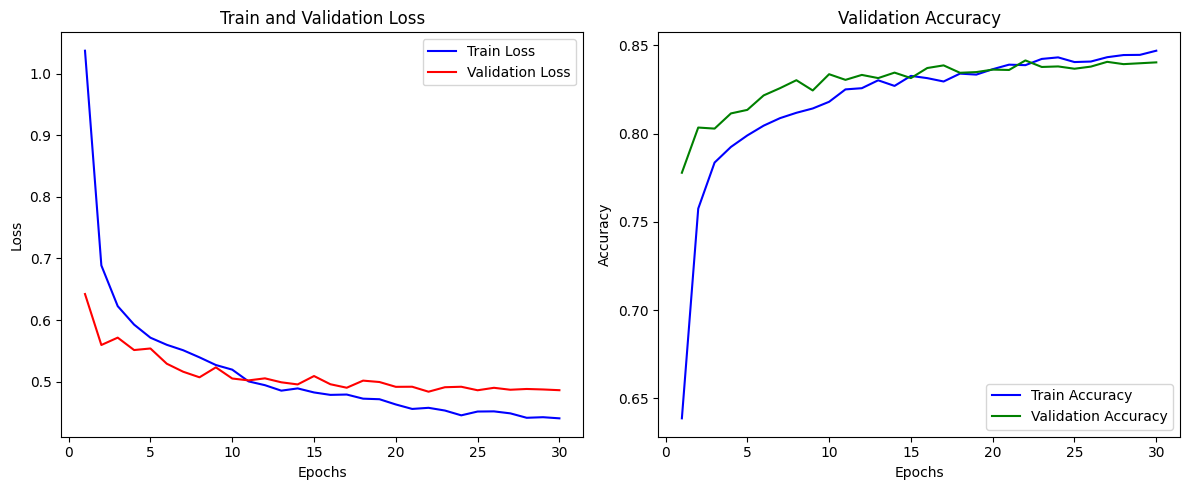

In [22]:
epochs = range(1, len(train_loss_history) + 1)

# График функции потерь на тренировочных данных
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_history, 'b', label='Train Loss')
plt.plot(epochs, val_loss_history, 'r', label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# График точности на валидационных данных
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_history, 'b', label='Train Accuracy')
plt.plot(epochs, val_acc_history, 'g', label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Сделайте выводы о качестве обучения

Оцените тестовую метрику на тестовых данных

In [23]:
test_acc, test_loss = test(model, test_loader, criterion, device)
print('Test Loss: {:.4f}\nTest Accuracy: {:.4f}'.format(test_loss, test_acc))

Test Loss: 0.4861
Test Accuracy: 0.8403


## Что дальше?
Теперь, когда у вас есть все необходимое - экспериментируйте. Можете изменить все что угодно, креативность поощряется. Используйте новые модели, loss-функции, аугментацию, ансамбли, выдумывайте все, что сможете

## Критерии оценки
Accuracy - на тестовых данных
- $Accuracy \leq 0.67$ - 0 баллов
- $0.67 < Accuracy \leq 0.72$ - 2 балла
- $0.72 < Accuracy \leq 0.77$ - 4 балла
- $0.77 < Accuracy \leq 0.82$ - 6 баллов
- $0.82 < Accuracy \leq 0.87$ - 8 баллов
- $Accuracy > 0.87$ - 10 баллов